<a href="https://colab.research.google.com/github/anujott-codes/Credit-Loan-Approval/blob/main/Credit_Approval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Libraries

In [188]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, accuracy_score
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA

# from sdv.single_table import CTGANSynthesizer
# from sdv.metadata import SingleTableMetadata

import warnings
warnings.filterwarnings('ignore')

##Credit Card Approval

###import dataset

In [189]:
#using credit dataset from kaggle derived from UCI
credit_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Machine Learning/Project/Credit Card and Loan Approval/credit_approval_dataset.csv")
credit_df.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,Ethnicity,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,ZipCode,Income,Approved
0,1,30.83,0.000,1,1,Industrials,White,1.25,1,1,1,0,ByBirth,202,0,1
1,0,58.67,4.460,1,1,Materials,Black,3.04,1,1,6,0,ByBirth,43,560,1
2,0,24.50,0.500,1,1,Materials,Black,1.50,1,0,0,0,ByBirth,280,824,1
3,1,27.83,1.540,1,1,Industrials,White,3.75,1,1,5,1,ByBirth,100,3,1
4,1,20.17,5.625,1,1,Industrials,White,1.71,1,0,0,0,ByOtherMeans,120,0,1


###Generating Synthetic Data

In [190]:
# # --- Configuration ---
# INPUT_FILE = "clean_dataset.csv"
# OUTPUT_FILE = "ctgan_synthetic_credit_data_5000.csv"
# N_SAMPLES = 800
# N_EPOCHS = 500

# # 1. Load the dataset
# df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Machine Learning/Project/Credit Card and Loan Approval/credit_approval_dataset.csv")

# # 2. Define Metadata
# # Metadata is crucial: it tells the model which columns are discrete, continuous, etc.
# metadata = SingleTableMetadata()
# # Automatically infer the initial data types (sdtypes)
# metadata.detect_from_dataframe(data=df)

# # IMPORTANT: Manually adjust discrete/categorical columns for better CTGAN performance
# # Binary/discrete integer columns should be explicitly marked as 'categorical'.
# categorical_columns = [
#     'Gender', 'Married', 'BankCustomer', 'PriorDefault',
#     'Employed', 'DriversLicense', 'Approved', 'CreditScore', 'ZipCode'
# ]
# for col in categorical_columns:
#     if col in df.columns:
#         # Update the metadata to ensure the model treats these as distinct categories, not ordinal numbers
#         metadata.update_column(column_name=col, sdtype='categorical')

# # 3. Instantiate the CTGAN Synthesizer
# # This is the Generative Adversarial Network specialized for tabular data.
# synthesizer = CTGANSynthesizer(
#     metadata=metadata,
#     # Adjust hyperparameters for better results
#     enforce_min_max_values=True,
#     enforce_rounding=False,
#     epochs=N_EPOCHS
# )

# # 4. Train the Model (This may take several minutes)
# print(f"Starting CTGAN training for {N_EPOCHS} epochs...")
# synthesizer.fit(df)
# print("Training complete.")

# # 5. Generate Synthetic Data
# print(f"Generating {N_SAMPLES} synthetic records...")
# synthetic_data = synthesizer.sample(num_rows=N_SAMPLES)

# # 6. Save the Result
# synthetic_data.to_csv(OUTPUT_FILE, index=False)
# print(f"Successfully generated and saved {N_SAMPLES} records to {OUTPUT_FILE}")

# # 7. Quick Validation Check
# print("\n--- Validation Check ---")
# print("Original Data Shape:", df.shape)
# print("Synthetic Data Shape:", synthetic_data.shape)
# print("Synthetic Data Head:")
# print(synthetic_data.head())

In [191]:
# #checking null value
# synthetic_data.isna().sum()

In [192]:
# #checking duplicates
# synthetic_data.duplicated().sum()

In [193]:
# #description of synthetic data
# synthetic_data.describe()

In [194]:
# #concatenating synthetic data into final dataset
# credit_df = pd.concat((credit_df,synthetic_data), ignore_index=True)
# credit_df

In [195]:
# credit_df.to_csv('Final_credit_data.csv')

###EDA

In [196]:
#info regarding dataset
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          690 non-null    int64  
 1   Age             690 non-null    float64
 2   Debt            690 non-null    float64
 3   Married         690 non-null    int64  
 4   BankCustomer    690 non-null    int64  
 5   Industry        690 non-null    object 
 6   Ethnicity       690 non-null    object 
 7   YearsEmployed   690 non-null    float64
 8   PriorDefault    690 non-null    int64  
 9   Employed        690 non-null    int64  
 10  CreditScore     690 non-null    int64  
 11  DriversLicense  690 non-null    int64  
 12  Citizen         690 non-null    object 
 13  ZipCode         690 non-null    int64  
 14  Income          690 non-null    int64  
 15  Approved        690 non-null    int64  
dtypes: float64(3), int64(10), object(3)
memory usage: 86.4+ KB


In [197]:
#check null values
credit_df.isna().sum()

,0
Gender,0
Age,0
Debt,0
Married,0
BankCustomer,0
Industry,0
Ethnicity,0
YearsEmployed,0
PriorDefault,0
Employed,0


In [198]:
#check duplicates
credit_df.duplicated().sum()

np.int64(0)

In [199]:
#unique values per column
credit_df.nunique()

,0
Gender,2
Age,350
Debt,215
Married,2
BankCustomer,2
Industry,14
Ethnicity,5
YearsEmployed,132
PriorDefault,2
Employed,2


In [200]:
#description of the dataset
credit_df.describe()

,Gender,Age,Debt,Married,BankCustomer,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,ZipCode,Income,Approved
count,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.000000,690.00000,690.000000,690.000000,690.000000,690.000000
mean,0.695652,31.514116,4.758725,0.760870,0.763768,2.223406,0.523188,0.427536,2.40000,0.457971,180.547826,1017.385507,0.444928
std,0.460464,11.860245,4.978163,0.426862,0.425074,3.346513,0.499824,0.495080,4.86294,0.498592,173.970323,5210.102598,0.497318
min,0.000000,13.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,22.670000,1.000000,1.000000,1.000000,0.165000,0.000000,0.000000,0.00000,0.000000,60.000000,0.000000,0.000000
50%,1.000000,28.460000,2.750000,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,160.000000,5.000000,0.000000
75%,1.000000,37.707500,7.207500,1.000000,1.000000,2.625000,1.000000,1.000000,3.00000,1.000000,272.000000,395.500000,1.000000
max,1.000000,80.250000,28.000000,1.000000,1.000000,28.500000,1.000000,1.000000,67.00000,1.000000,2000.000000,100000.000000,1.000000


In [201]:
#unique industries
credit_df['Industry'].unique()

array(['Industrials', 'Materials', 'CommunicationServices', 'Transport',
       'InformationTechnology', 'Financials', 'Energy', 'Real Estate',
       'Utilities', 'ConsumerDiscretionary', 'Education',
       'ConsumerStaples', 'Healthcare', 'Research'], dtype=object)

In [202]:
credit_df['Citizen'].unique()

array(['ByBirth', 'ByOtherMeans', 'Temporary'], dtype=object)

In [203]:
#extracting numerical features and categorical features
num_features = credit_df.select_dtypes(exclude='O').columns.to_list()
cat_features = credit_df.select_dtypes(include='O').columns.to_list()

print("----- Numerical Features -----")
print(num_features)
print(f"Total : {len(num_features)}")
print("\n")
print("----- Categorical Features -----")
print(cat_features)
print(f"Total : {len(cat_features)}")

----- Numerical Features -----
['Gender', 'Age', 'Debt', 'Married', 'BankCustomer', 'YearsEmployed', 'PriorDefault', 'Employed', 'CreditScore', 'DriversLicense', 'ZipCode', 'Income', 'Approved']
Total : 13


----- Categorical Features -----
['Industry', 'Ethnicity', 'Citizen']
Total : 3


In [204]:
#function to plot distributions
def plot(df, col ,num):
  plt.subplot(4,4,num)
  sns.histplot(data = df,x=col,kde=True, color='skyblue')
  plt.title(f"{col} Distribution")
  plt.xlabel(" ")

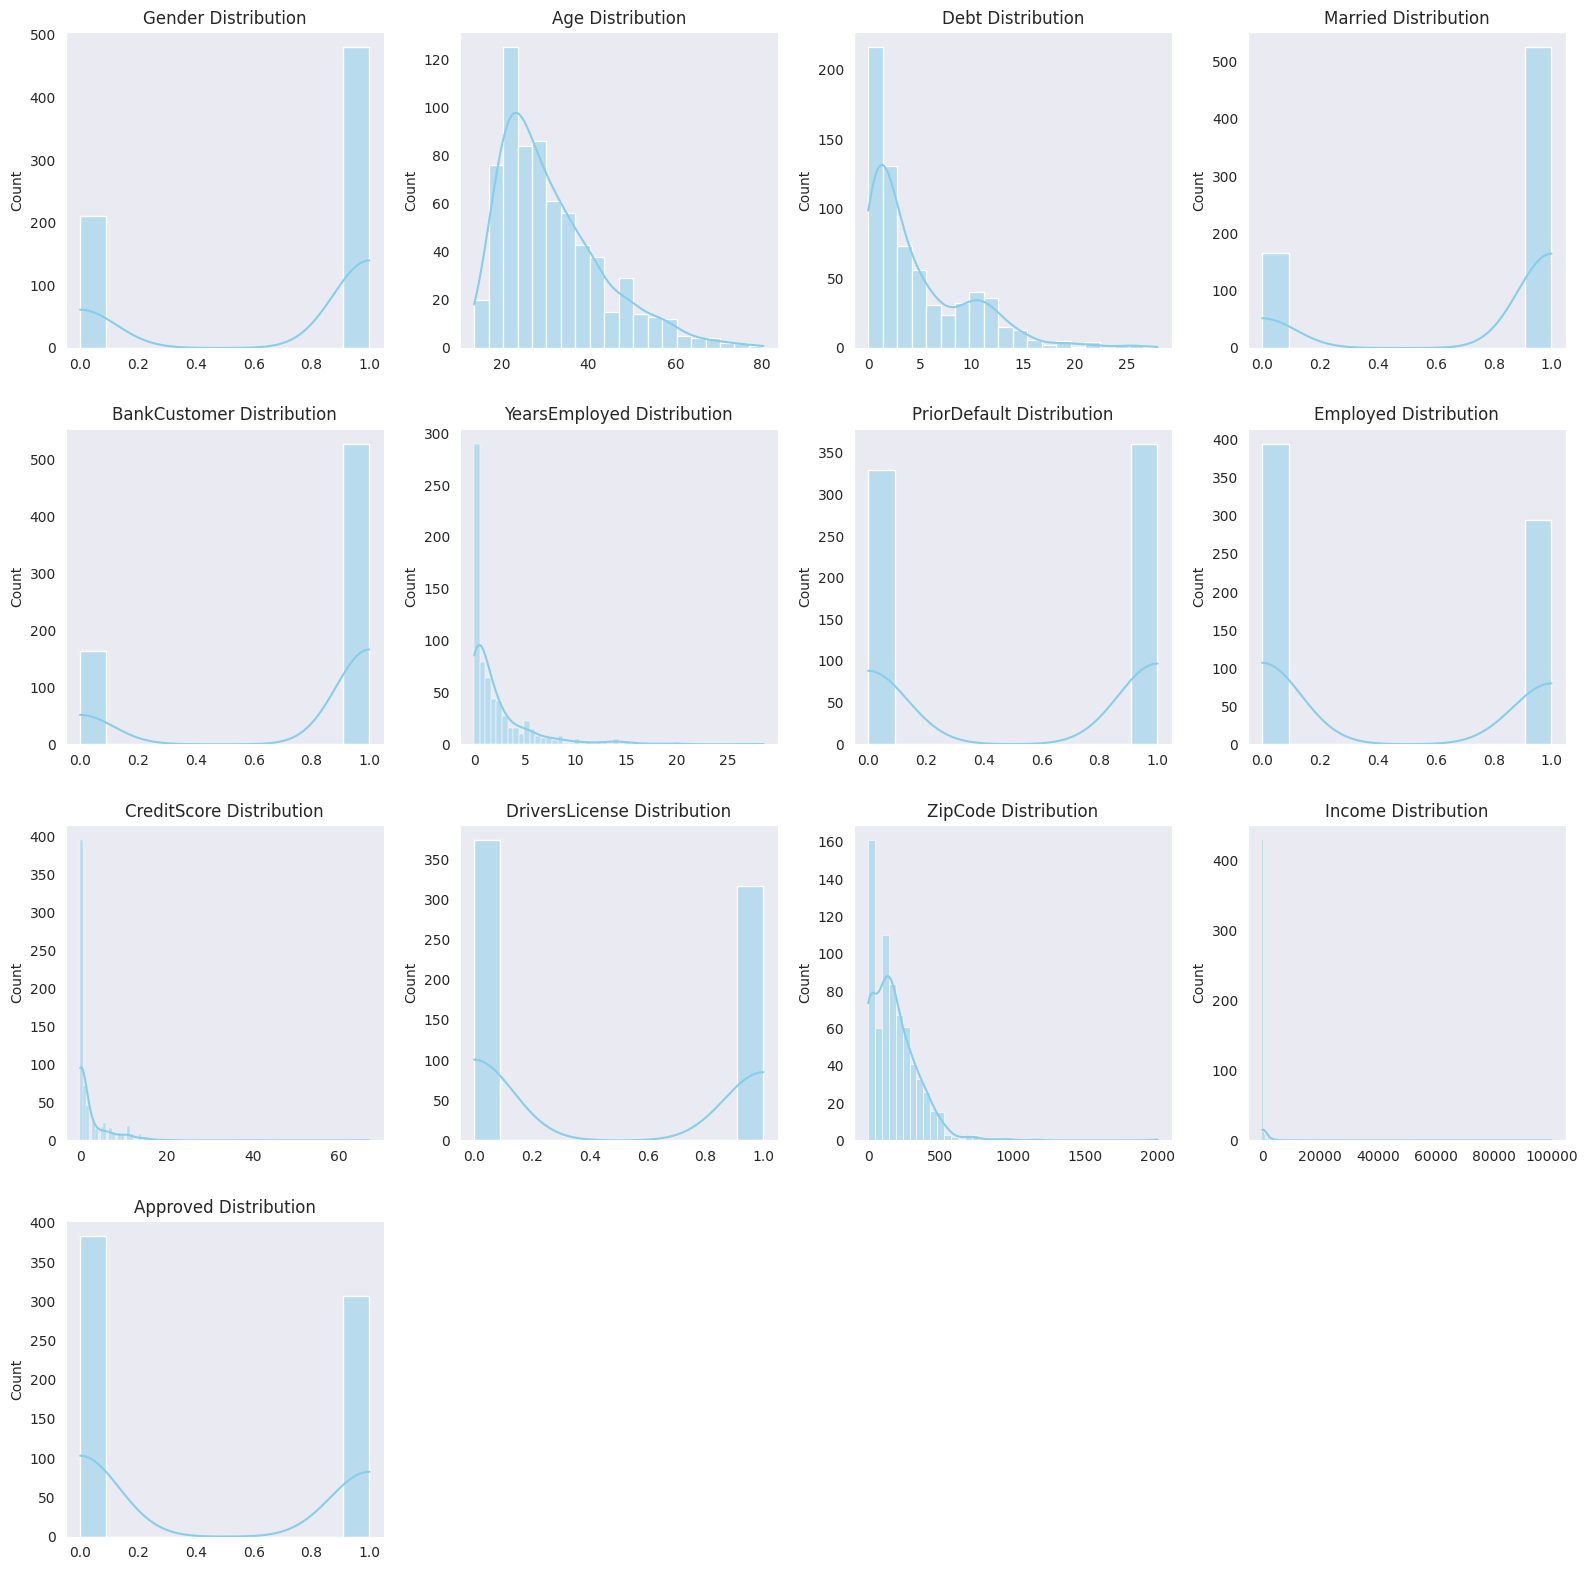

In [205]:
#plotting distributions
plt.figure(figsize=(16,16))
for i,col in enumerate(num_features):
  plot(credit_df,col,i+1)

plt.tight_layout()
plt.show()

Debt,Incmome and Credit Score have been already scaled

In [206]:
#function for pie chart
def pie_plot(col, num, df=credit_df):
    plt.subplot(3,3,num)
    plt.pie(
        df[col].value_counts(),
        labels=df[col].value_counts().index,
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel')
    )
    plt.title(f"{col} Distribution")


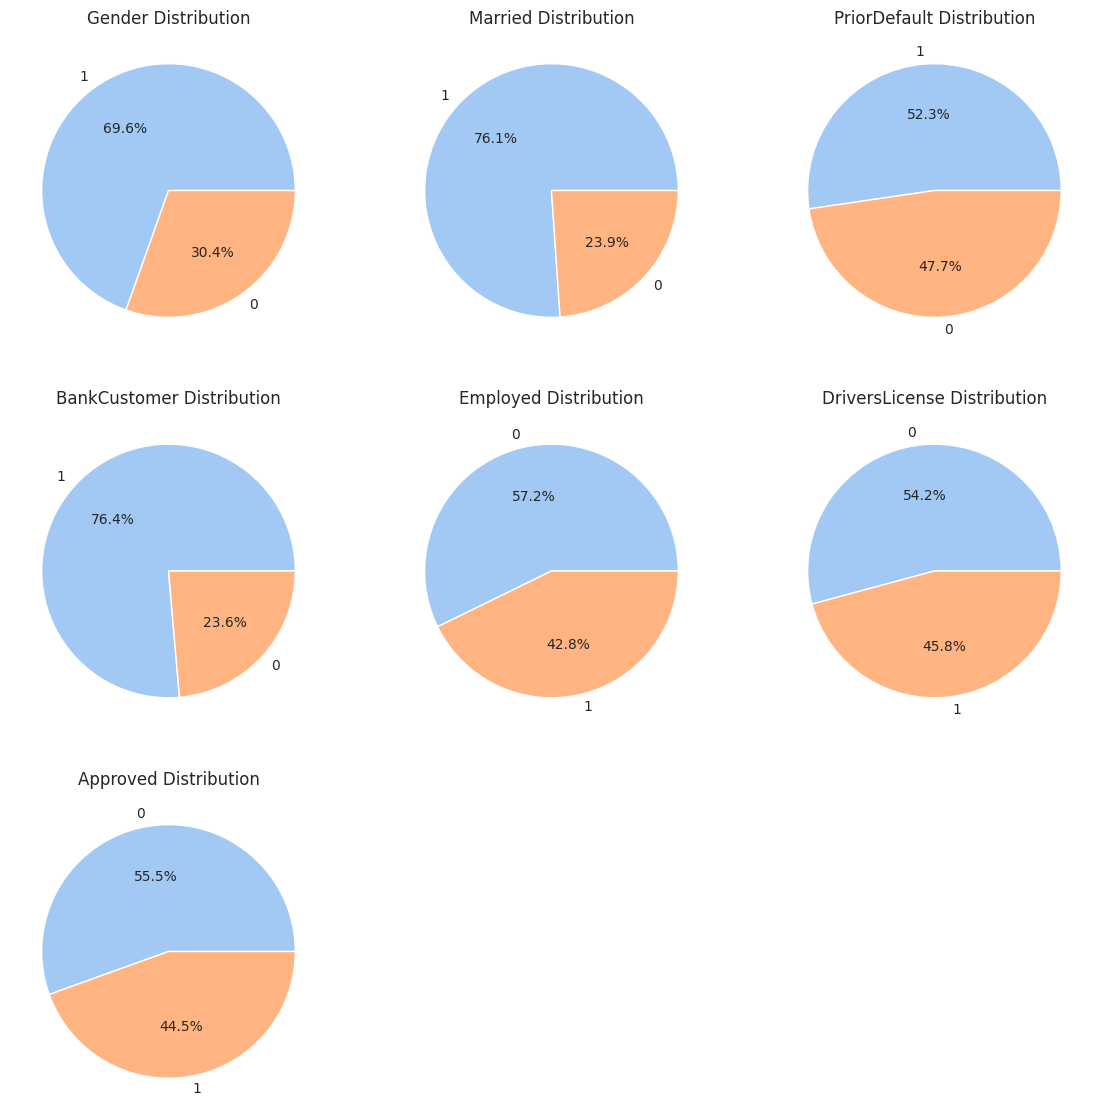

In [207]:
#pie chart for binary distributions
plt.figure(figsize=(14,14))
binary_features = ['Gender','Married','PriorDefault','BankCustomer','Employed','DriversLicense','Approved']
for i,col in enumerate(binary_features):
  pie_plot(col,i+1)
plt.show()

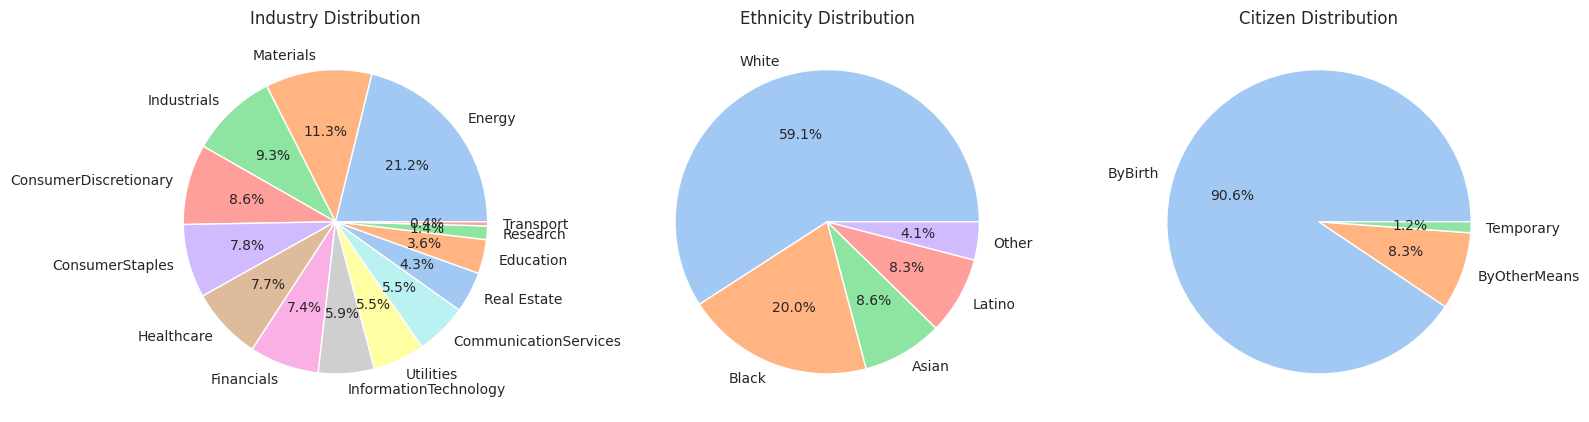

In [208]:
#pie chart for categorical features
plt.figure(figsize=(16,16))
for i,col in enumerate(cat_features):
  pie_plot(col,i+1)

plt.tight_layout()
plt.show()

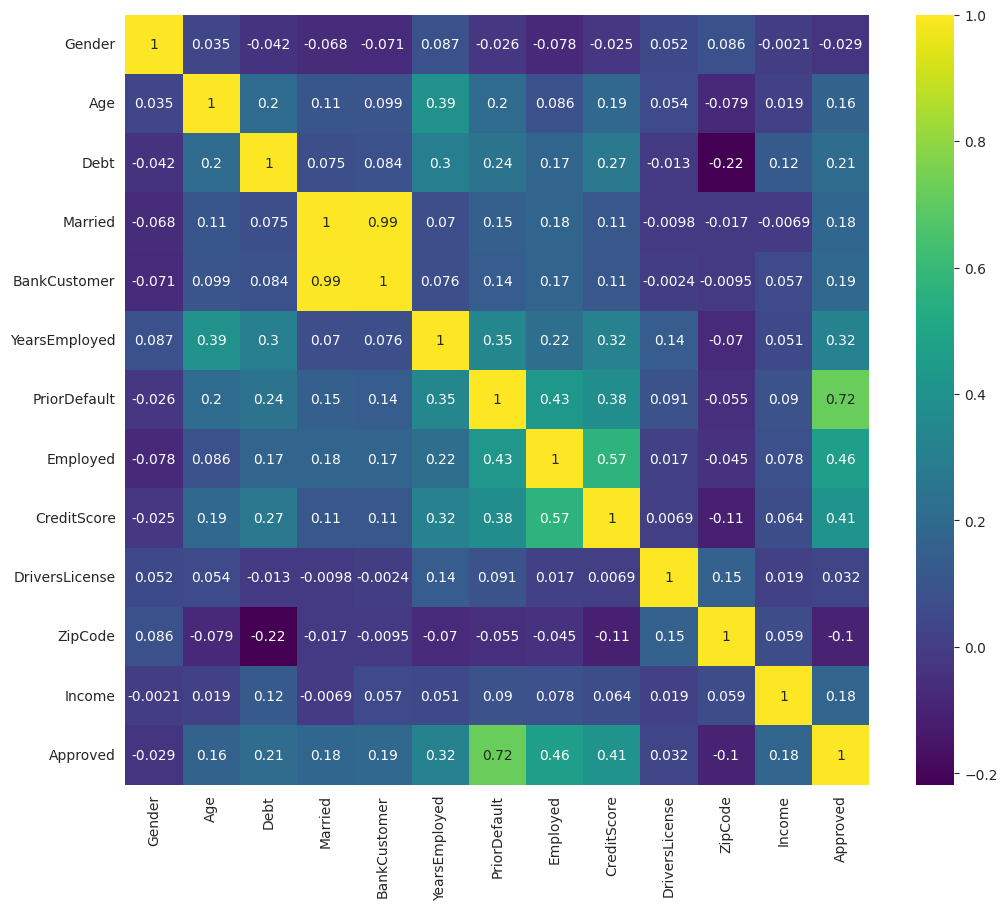

In [209]:
#check collinearity and feature correlation
plt.figure(figsize=(12,10))
numeric_df = credit_df.select_dtypes(exclude='O')
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, cmap='viridis',annot=True)
plt.show()

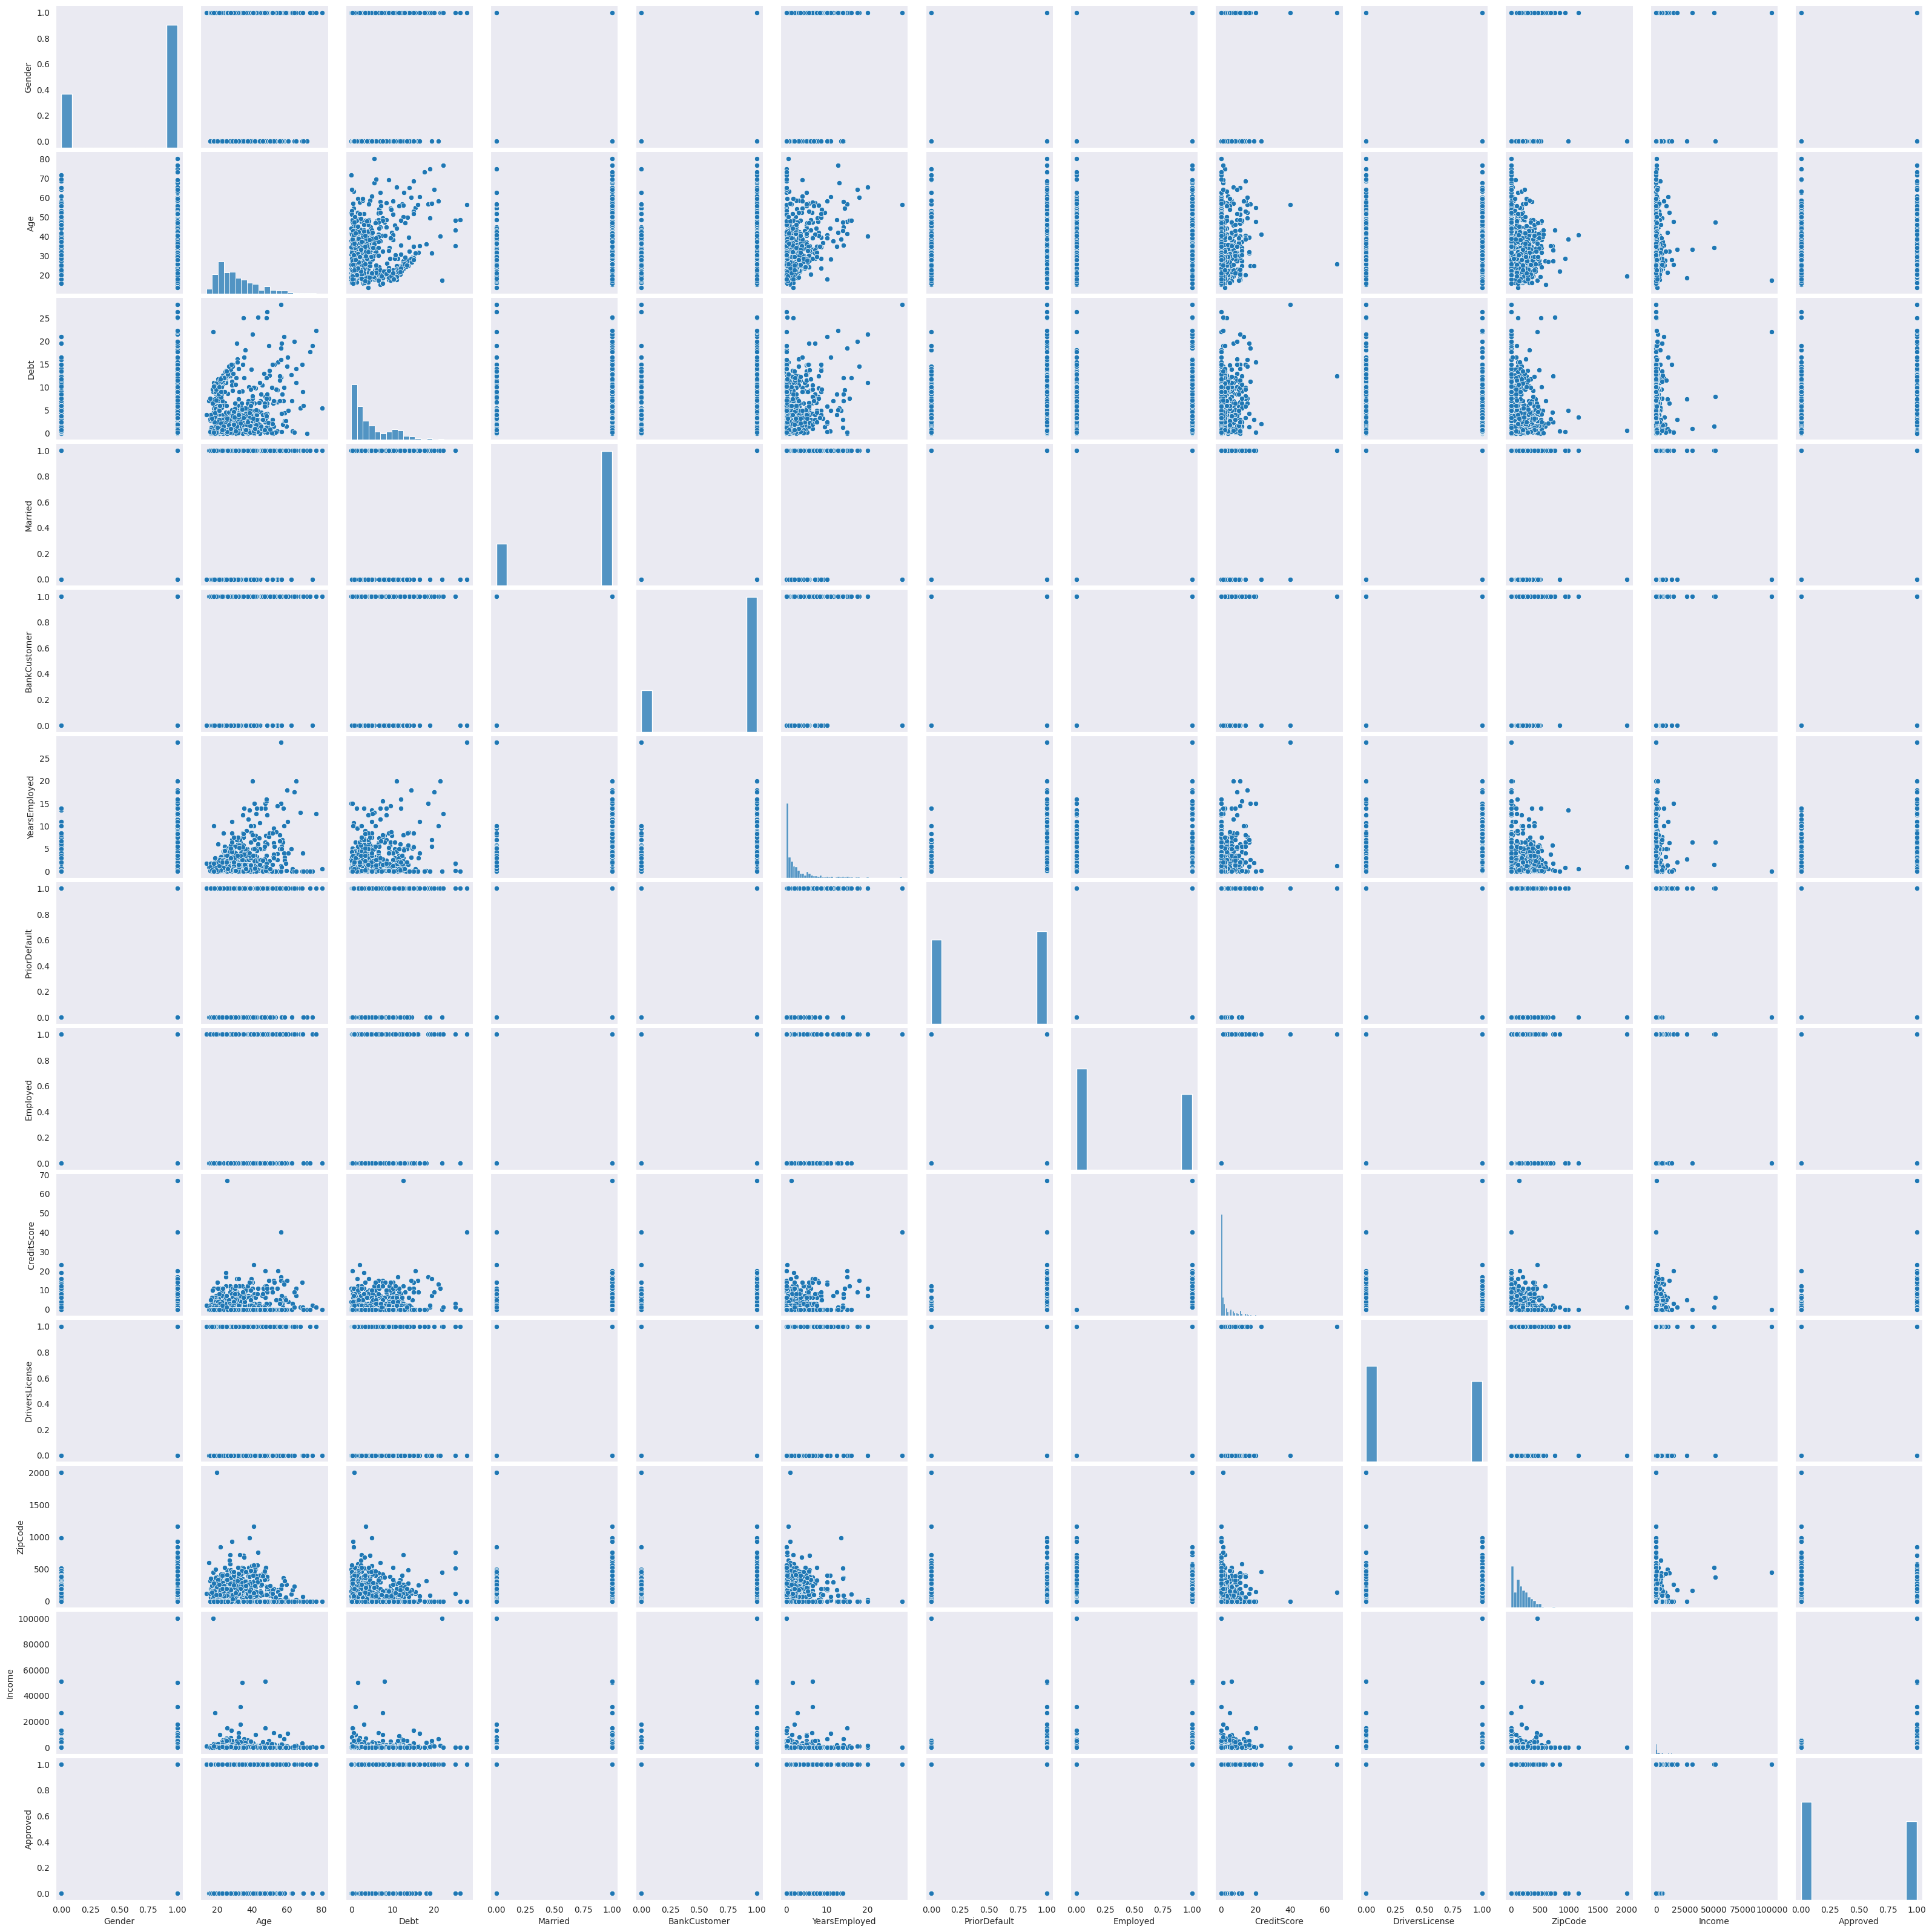

In [210]:
#pairplot
sns.pairplot(data = credit_df)
plt.show()

In [211]:
#dropping less informative features
final_df = credit_df.copy()
final_df = final_df.drop(columns=['Ethnicity','ZipCode'])
final_df.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income,Approved
0,1,30.83,0.000,1,1,Industrials,1.25,1,1,1,0,ByBirth,0,1
1,0,58.67,4.460,1,1,Materials,3.04,1,1,6,0,ByBirth,560,1
2,0,24.50,0.500,1,1,Materials,1.50,1,0,0,0,ByBirth,824,1
3,1,27.83,1.540,1,1,Industrials,3.75,1,1,5,1,ByBirth,3,1
4,1,20.17,5.625,1,1,Industrials,1.71,1,0,0,0,ByOtherMeans,0,1


In [212]:
final_df.shape

(690, 14)

In [213]:
#continuous distributions
continuous_features = ['Age','Debt','YearsEmployed','CreditScore','Income']

In [214]:
#function for box plot to analyse outliers
def boxplot(col,num,df=final_df):
  plt.subplot(3,3,num)
  sns.set_style('dark')
  sns.boxplot(data = df,x = col, color='purple')
  plt.title(f'{col} Boxplot Distribution')

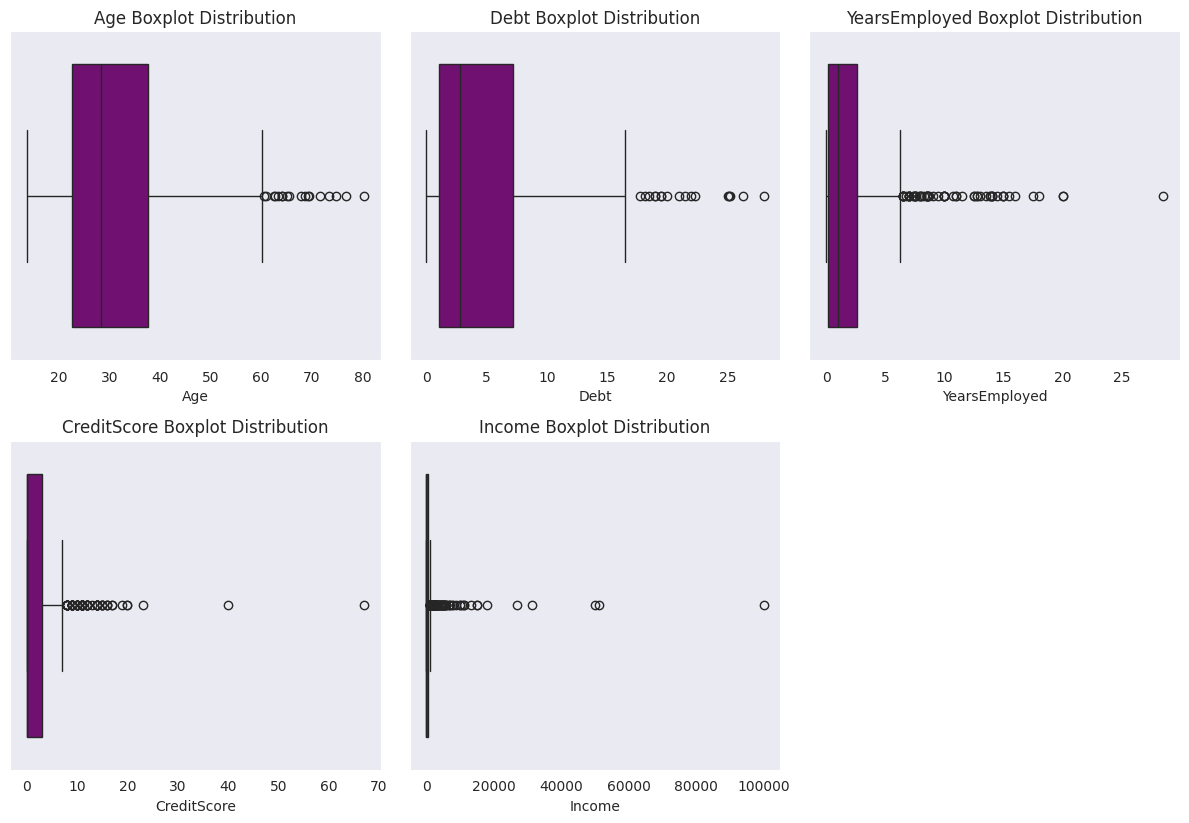

In [215]:
#plotting boxplot for continuous distributions
plt.figure(figsize=(12,12))
for i,col in enumerate(continuous_features):
  boxplot(col,i+1)

plt.tight_layout()
plt.show()

In [216]:
#outlier capping to prevent information loss
def cap_outliers_clip(df, column, lower_percentile=0.01, upper_percentile=0.99):
    q_low = df[column].quantile(lower_percentile)
    q_high = df[column].quantile(upper_percentile)


    df[column] = df[column].clip(lower=q_low, upper=q_high)
    return df

In [217]:
for col in continuous_features:
    final_df = cap_outliers_clip(final_df, col)

In [218]:
#log transformation on highly skewed cols
final_df['CreditScore'] = np.log1p(final_df['CreditScore'])
final_df['Income'] = np.log1p(final_df['Income'])
final_df['YearsEmployed'] = np.log1p(final_df['YearsEmployed'])

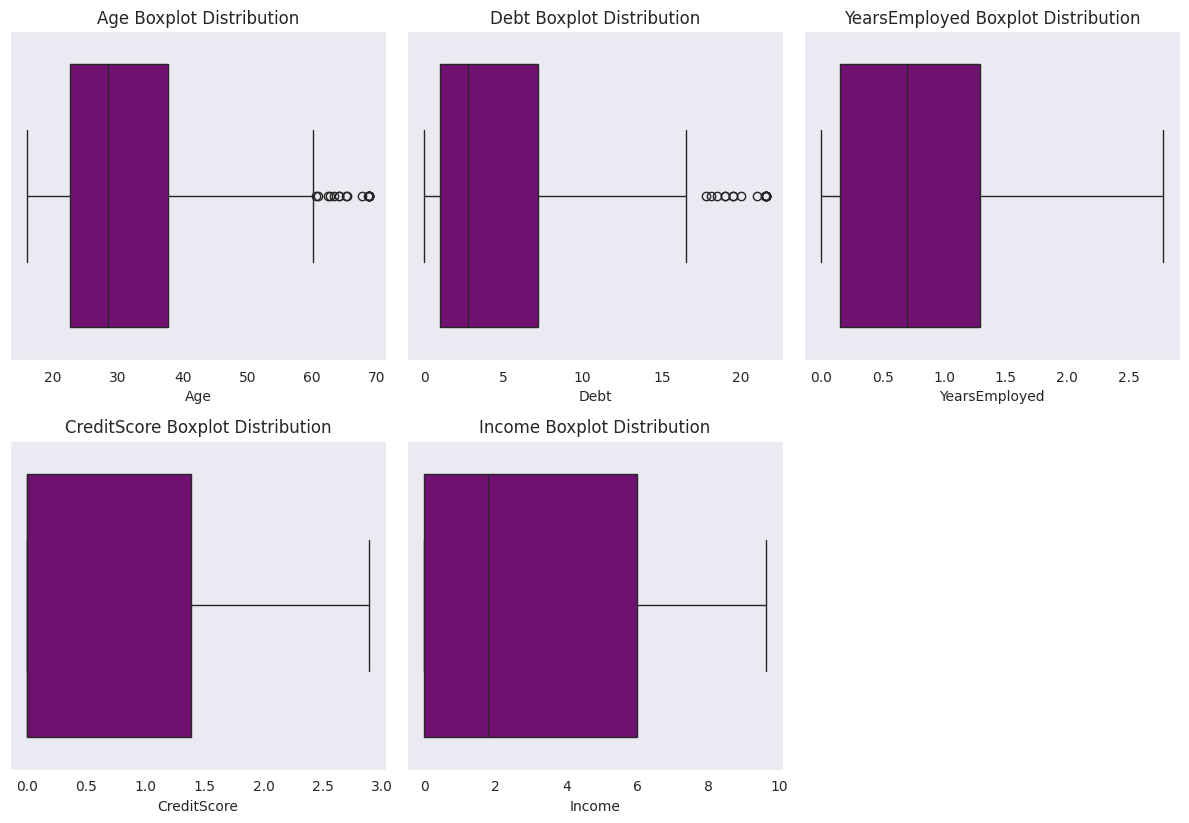

In [219]:
#plotting boxplot for continuous distributions
plt.figure(figsize=(12,12))
for i,col in enumerate(continuous_features):
  boxplot(col,i+1)

plt.tight_layout()
plt.show()

##Data Split

In [220]:
X = final_df.drop(columns = ['Approved'])
y = final_df['Approved']

In [221]:
X.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income
0,1,30.83,0.000,1,1,Industrials,0.810930,1,1,0.693147,0,ByBirth,0.000000
1,0,58.67,4.460,1,1,Materials,1.396245,1,1,1.945910,0,ByBirth,6.329721
2,0,24.50,0.500,1,1,Materials,0.916291,1,0,0.000000,0,ByBirth,6.715383
3,1,27.83,1.540,1,1,Industrials,1.558145,1,1,1.791759,1,ByBirth,1.386294
4,1,20.17,5.625,1,1,Industrials,0.996949,1,0,0.000000,0,ByOtherMeans,0.000000


In [222]:
#data split for training set and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [223]:
X_train.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income
177,0,26.08,8.665,1,1,ConsumerStaples,0.881699,1,0,0.000000,0,ByBirth,5.017280
401,1,28.92,0.375,1,1,Energy,0.254642,0,0,0.000000,0,ByBirth,4.948760
375,0,20.83,0.500,0,0,Education,0.693147,0,0,0.000000,0,ByBirth,0.000000
299,1,22.17,12.125,1,1,Energy,1.466722,0,1,1.098612,1,ByBirth,5.159055
45,1,54.33,6.750,1,1,Energy,1.287854,1,1,2.484907,1,ByBirth,5.652489


In [224]:
X_test.head()

,Gender,Age,Debt,Married,BankCustomer,Industry,YearsEmployed,PriorDefault,Employed,CreditScore,DriversLicense,Citizen,Income
53,1,34.92,2.500,1,1,Industrials,0.000000,1,0,0.000000,1,ByBirth,5.303305
52,1,37.42,2.040,1,1,Industrials,0.039221,1,0,0.000000,1,ByBirth,8.665786
407,0,19.58,0.665,0,0,Energy,0.693147,0,1,0.693147,0,ByBirth,1.098612
191,1,42.00,0.205,1,1,ConsumerDiscretionary,1.812379,1,0,0.000000,0,ByBirth,0.000000
492,1,39.25,9.500,1,1,CommunicationServices,2.014903,1,1,2.708050,0,ByBirth,8.435549


In [225]:
#setup preprocessor
#extracting numerical and categorical features
categorical_features = X_train.select_dtypes(include='O').columns.to_list()
binary_features.remove('Approved')


preprocessor = ColumnTransformer(
    transformers=[
        ('bin','passthrough',binary_features),
        ('num',StandardScaler(),continuous_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

#preprocessing X_train and X_test
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [226]:
#saving preprocessor for deployment
joblib.dump(preprocessor,'preprocessor.pkl')

['preprocessor.pkl']

In [227]:
#logistic Regression
lr = LogisticRegression(random_state = 42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold CV
lr_scores = cross_val_score(lr, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", lr_scores)
print("Mean accuracy:", lr_scores.mean())
print("Standard deviation:", lr_scores.std())



Accuracy scores for each fold: [0.89189189 0.83783784 0.88181818 0.80909091 0.82727273]
Mean accuracy: 0.8495823095823096
Standard deviation: 0.031951387472717085


In [228]:
#SVC
svc = SVC(random_state = 42,probability=True)

# Perform 5-fold CV
svc_scores = cross_val_score(svc, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", svc_scores)
print("Mean accuracy:", svc_scores.mean())
print("Standard deviation:", svc_scores.std())

Accuracy scores for each fold: [0.87387387 0.83783784 0.88181818 0.81818182 0.82727273]
Mean accuracy: 0.8477968877968879
Standard deviation: 0.0254359345782947


In [229]:
#KNN
knn = KNeighborsClassifier()

# Perform 5-fold CV
knn_scores = cross_val_score(knn, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", knn_scores)
print("Mean accuracy:", knn_scores.mean())
print("Standard deviation:", knn_scores.std())

Accuracy scores for each fold: [0.89189189 0.76576577 0.81818182 0.81818182 0.79090909]
Mean accuracy: 0.8169860769860771
Standard deviation: 0.04223096064520308


In [230]:
#Naive Bayes
nb = GaussianNB()

# Perform 5-fold CV
nb_scores = cross_val_score(nb, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", nb_scores)
print("Mean accuracy:", nb_scores.mean())
print("Standard deviation:", nb_scores.std())

Accuracy scores for each fold: [0.85585586 0.83783784 0.74545455 0.79090909 0.81818182]
Mean accuracy: 0.8096478296478298
Standard deviation: 0.038664208961599285


In [231]:
#RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform 5-fold CV
rf_scores = cross_val_score(rf, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", rf_scores)
print("Mean accuracy:", rf_scores.mean())
print("Standard deviation:", rf_scores.std())

Accuracy scores for each fold: [0.88288288 0.83783784 0.88181818 0.83636364 0.80909091]
Mean accuracy: 0.8495986895986896
Standard deviation: 0.02863668190067908


In [232]:
#GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=22)

# Perform 5-fold CV
gb_scores = cross_val_score(gb, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", gb_scores)
print("Mean accuracy:", gb_scores.mean())
print("Standard deviation:", gb_scores.std())

Accuracy scores for each fold: [0.88288288 0.83783784 0.85454545 0.80909091 0.80909091]
Mean accuracy: 0.8386895986895986
Standard deviation: 0.028133058423064503


In [233]:
#XGBClassifier
xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    objective='binary:logistic'
)

# Perform 5-fold CV
xgb_scores = cross_val_score(xgb, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", xgb_scores)
print("Mean accuracy:", xgb_scores.mean())
print("Standard deviation:", xgb_scores.std())

Accuracy scores for each fold: [0.86486486 0.81981982 0.83636364 0.84545455 0.78181818]
Mean accuracy: 0.8296642096642097
Standard deviation: 0.02799806257968277


LogisticRegression, SVC, Random Forests perform well

##Evaluation on Testing Set

In [234]:
#logistic regression
lr.fit(X_train_preprocessed,y_train)

#prediction on training set
ypred_train_lr = lr.predict(X_train_preprocessed)

#prediction on testing set
ypred_test_lr = lr.predict(X_test_preprocessed)

#classifiction report for training set
clf_report_train_lr = classification_report(y_train,ypred_train_lr)
print("----- Classification report for Training Set -----")
print(clf_report_train_lr)

#classification report for testing set
clf_report_test_lr = classification_report(y_test,ypred_test_lr)
print("----- Classification report for Testing Set -----")
print(clf_report_test_lr)

----- Classification report for Training Set -----
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       306
           1       0.85      0.85      0.85       246

    accuracy                           0.87       552
   macro avg       0.86      0.86      0.86       552
weighted avg       0.87      0.87      0.87       552

----- Classification report for Testing Set -----
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        77
           1       0.88      0.82      0.85        61

    accuracy                           0.87       138
   macro avg       0.87      0.86      0.87       138
weighted avg       0.87      0.87      0.87       138



In [235]:
# Support Vector Classifier
svc.fit(X_train_preprocessed,y_train)

#prediction on training set
ypred_train_svc = svc.predict(X_train_preprocessed)

#prediction on testing set
ypred_test_svc = svc.predict(X_test_preprocessed)

#classifiction report for training set
clf_report_train_svc = classification_report(y_train,ypred_train_svc)
print("----- Classification report for Training Set -----")
print(clf_report_train_svc)

#classification report for testing set
clf_report_test_svc = classification_report(y_test,ypred_test_svc)
print("----- Classification report for Testing Set -----")
print(clf_report_test_svc)


----- Classification report for Training Set -----
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       306
           1       0.90      0.87      0.88       246

    accuracy                           0.90       552
   macro avg       0.90      0.90      0.90       552
weighted avg       0.90      0.90      0.90       552

----- Classification report for Testing Set -----
              precision    recall  f1-score   support

           0       0.86      0.94      0.89        77
           1       0.91      0.80      0.85        61

    accuracy                           0.88       138
   macro avg       0.88      0.87      0.87       138
weighted avg       0.88      0.88      0.88       138



In [236]:
#Random Forest Classifier
rf.fit(X_train_preprocessed,y_train)

#prediction on training set
ypred_train_rf = rf.predict(X_train_preprocessed)

#prediction on testing set
ypred_test_rf = rf.predict(X_test_preprocessed)

#classifiction report for training set
clf_report_train_rf = classification_report(y_train,ypred_train_rf)
print("----- Classification report for Training Set -----")
print(clf_report_train_rf)

#classification report for testing set
clf_report_test_rf = classification_report(y_test,ypred_test_rf)
print("----- Classification report for Testing Set -----")
print(clf_report_test_rf)

----- Classification report for Training Set -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       306
           1       1.00      1.00      1.00       246

    accuracy                           1.00       552
   macro avg       1.00      1.00      1.00       552
weighted avg       1.00      1.00      1.00       552

----- Classification report for Testing Set -----
              precision    recall  f1-score   support

           0       0.86      0.94      0.89        77
           1       0.91      0.80      0.85        61

    accuracy                           0.88       138
   macro avg       0.88      0.87      0.87       138
weighted avg       0.88      0.88      0.88       138



In [237]:
#XGBoost Classifier
xgb.fit(X_train_preprocessed,y_train)

#prediction on training set
ypred_train_xgb = xgb.predict(X_train_preprocessed)

#prediction on testing set
ypred_test_xgb = xgb.predict(X_test_preprocessed)

#classifiction report for training set
clf_report_train_xgb = classification_report(y_train,ypred_train_xgb)
print("----- Classification report for Training Set -----")
print(clf_report_train_xgb)

#classification report for testing set
clf_report_test_xgb = classification_report(y_test,ypred_test_xgb)
print("----- Classification report for Testing Set -----")
print(clf_report_test_xgb)

----- Classification report for Training Set -----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       306
           1       1.00      1.00      1.00       246

    accuracy                           1.00       552
   macro avg       1.00      1.00      1.00       552
weighted avg       1.00      1.00      1.00       552

----- Classification report for Testing Set -----
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        77
           1       0.90      0.87      0.88        61

    accuracy                           0.90       138
   macro avg       0.90      0.90      0.90       138
weighted avg       0.90      0.90      0.90       138



SVC Performs the Best

##Confusion Matrix, ROC_AUC curve and Evaluation metrics

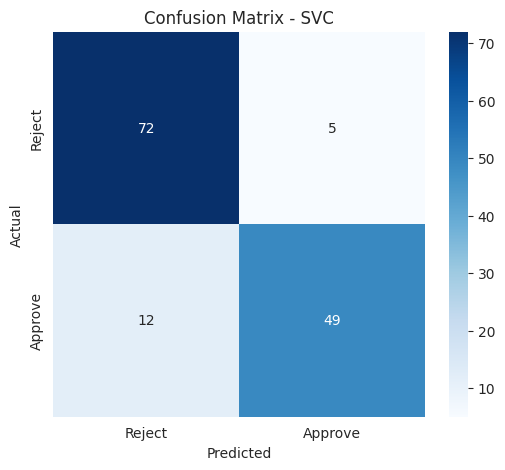

In [238]:
#confusion matrix
cm = confusion_matrix(y_test,ypred_test_svc)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Reject','Approve'], yticklabels=['Reject','Approve'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVC')
plt.show()

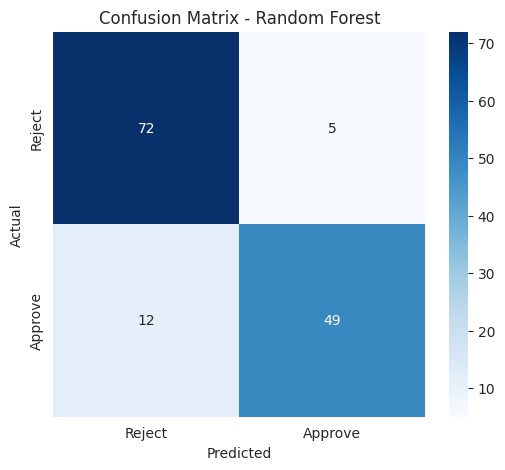

In [239]:
#confusion matrix
cm = confusion_matrix(y_test,ypred_test_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Reject','Approve'], yticklabels=['Reject','Approve'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.show()

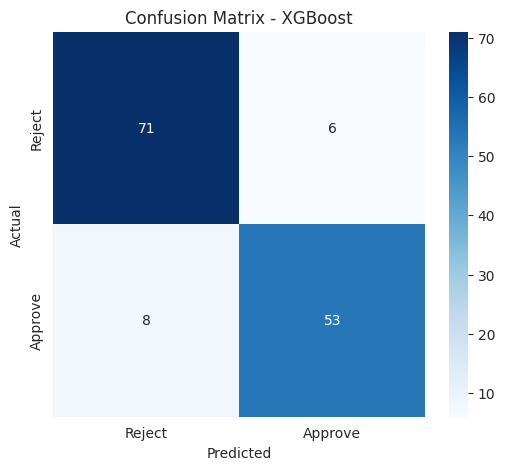

In [240]:
#confusion matrix
cm = confusion_matrix(y_test,ypred_test_xgb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Reject','Approve'], yticklabels=['Reject','Approve'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

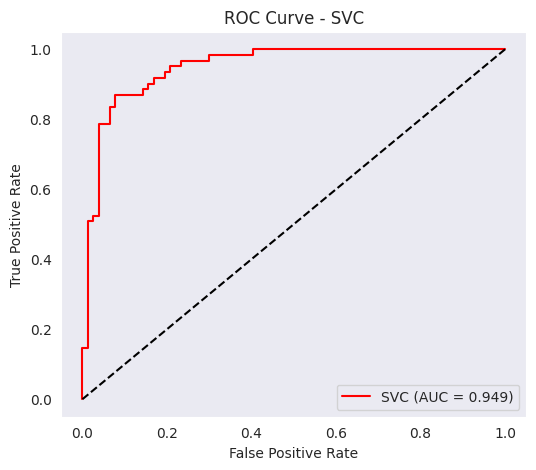

In [242]:
#ROC-AUC curve
yprob_svc = svc.predict_proba(X_test_preprocessed)[:,1]
auc_score = roc_auc_score(y_test, yprob_svc)
fpr, tpr, thresholds = roc_curve(y_test, yprob_svc)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"SVC (AUC = {auc_score:.3f})",color='red')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVC')
plt.legend(loc='lower right')
plt.show()

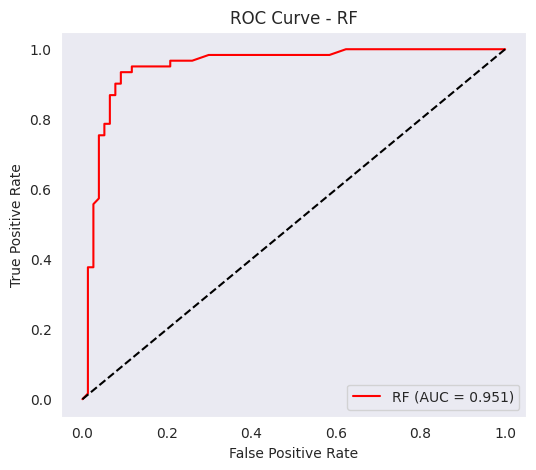

In [243]:
#ROC-AUC curve
yprob_rf = rf.predict_proba(X_test_preprocessed)[:,1]
auc_score = roc_auc_score(y_test, yprob_rf)
fpr, tpr, thresholds = roc_curve(y_test, yprob_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"RF (AUC = {auc_score:.3f})",color='red')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RF')
plt.legend(loc='lower right')
plt.show()

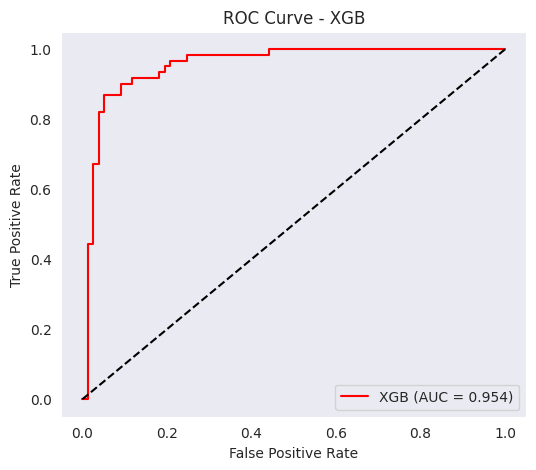

In [252]:
#ROC-AUC curve
yprob_xgb = xgb.predict_proba(X_test_preprocessed)[:,1]
auc_score = roc_auc_score(y_test, yprob_xgb)
fpr, tpr, thresholds = roc_curve(y_test, yprob_xgb)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"XGB (AUC = {auc_score:.3f})",color='red')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGB')
plt.legend(loc='lower right')
plt.show()

##Hyperparameter Tuning

In [254]:
# Define parameter grid
rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Randomized Search
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_params,
    n_iter=50,
    scoring='accuracy',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train_preprocessed, y_train)
print("Best Parameters for Random Forest:\n", rf_random.best_params_)
print("Best CV Accuracy:", rf_random.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters for Random Forest:
 {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': True}
Best CV Accuracy: 0.8676822276822277


In [256]:
#tuned Random Forest Classifier
tuned_rf = RandomForestClassifier(
    n_estimators=400,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features='log2',
    max_depth=5,
    bootstrap=True,
    random_state=42
)

# Perform 5-fold CV
tuned_rf_scores = cross_val_score(tuned_rf, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", tuned_rf_scores)
print("Mean accuracy:", tuned_rf_scores.mean())
print("Standard deviation:", tuned_rf_scores.std())

Accuracy scores for each fold: [0.89189189 0.84684685 0.89090909 0.82727273 0.82727273]
Mean accuracy: 0.8568386568386568
Standard deviation: 0.029112363059540833


In [257]:
#Random Forest Classifier
tuned_rf.fit(X_train_preprocessed,y_train)

#prediction on training set
ypred_train_rf_tuned = tuned_rf.predict(X_train_preprocessed)

#prediction on testing set
ypred_test_rf_tuned = tuned_rf.predict(X_test_preprocessed)

#classifiction report for training set
clf_report_train_rf_tuned = classification_report(y_train,ypred_train_rf_tuned)
print("----- Classification report for Training Set -----")
print(clf_report_train_rf_tuned)

#classification report for testing set
clf_report_test_rf_tuned = classification_report(y_test,ypred_test_rf_tuned)
print("----- Classification report for Testing Set -----")
print(clf_report_test_rf_tuned)

----- Classification report for Training Set -----
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       306
           1       0.92      0.82      0.87       246

    accuracy                           0.89       552
   macro avg       0.89      0.88      0.88       552
weighted avg       0.89      0.89      0.89       552

----- Classification report for Testing Set -----
              precision    recall  f1-score   support

           0       0.85      0.96      0.90        77
           1       0.94      0.79      0.86        61

    accuracy                           0.88       138
   macro avg       0.90      0.87      0.88       138
weighted avg       0.89      0.88      0.88       138



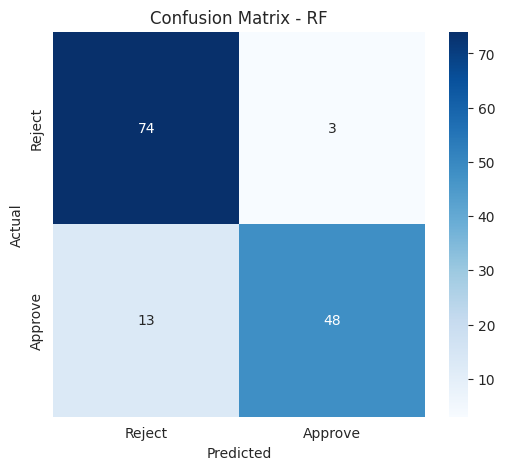

In [258]:
#confusion matrix
cm = confusion_matrix(y_test,ypred_test_rf_tuned)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Reject','Approve'], yticklabels=['Reject','Approve'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - RF')
plt.show()

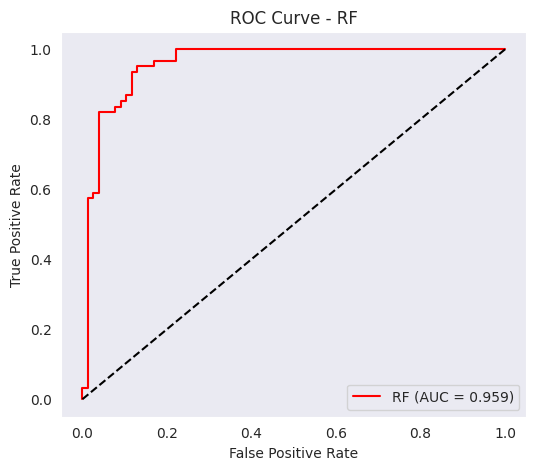

In [259]:
#ROC-AUC curve
yprob_rf = tuned_rf.predict_proba(X_test_preprocessed)[:,1]
auc_score = roc_auc_score(y_test, yprob_rf)
fpr, tpr, thresholds = roc_curve(y_test, yprob_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"RF (AUC = {auc_score:.3f})",color='red')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RF')
plt.legend(loc='lower right')
plt.show()

In [248]:
#XGB tuning
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'min_child_weight': [1, 3, 5]
}

#randomized search
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=40,
    scoring='accuracy',
    n_jobs=-1,
    cv=skf,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_preprocessed, y_train)

#Best parameters and performance
print("\nBest Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best Parameters: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.7}
Best CV Accuracy: 0.8568386568386568


In [249]:
#tuned XGB Classifier
tuned_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    subsample=1.0,
    n_estimators=300,
    min_child_weight=5,
    max_depth=3,
    learning_rate=0.01,
    gamma=0.3,
    colsample_bytree=0.7,
    random_state=42
)

# Perform 5-fold CV
tuned_xgb_scores = cross_val_score(tuned_xgb, X_train_preprocessed, y_train, cv=skf, scoring='accuracy')

print("Accuracy scores for each fold:", tuned_xgb_scores)
print("Mean accuracy:", tuned_xgb_scores.mean())
print("Standard deviation:", tuned_xgb_scores.std())

Accuracy scores for each fold: [0.88288288 0.85585586 0.86363636 0.85454545 0.82727273]
Mean accuracy: 0.8568386568386568
Standard deviation: 0.017915799695113702


In [250]:
#XGBoost Classifier
tuned_xgb.fit(X_train_preprocessed,y_train)

#prediction on training set
ypred_train_xgb_tuned = tuned_xgb.predict(X_train_preprocessed)

#prediction on testing set
ypred_test_xgb_tuned = tuned_xgb.predict(X_test_preprocessed)

#classifiction report for training set
clf_report_train_xgb_tuned = classification_report(y_train,ypred_train_xgb_tuned)
print("----- Classification report for Training Set -----")
print(clf_report_train_xgb_tuned)

#classification report for testing set
clf_report_test_xgb_tuned = classification_report(y_test,ypred_test_xgb_tuned)
print("----- Classification report for Testing Set -----")
print(clf_report_test_xgb_tuned)

----- Classification report for Training Set -----
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       306
           1       0.88      0.85      0.87       246

    accuracy                           0.88       552
   macro avg       0.88      0.88      0.88       552
weighted avg       0.88      0.88      0.88       552

----- Classification report for Testing Set -----
              precision    recall  f1-score   support

           0       0.87      0.94      0.90        77
           1       0.91      0.82      0.86        61

    accuracy                           0.88       138
   macro avg       0.89      0.88      0.88       138
weighted avg       0.89      0.88      0.88       138



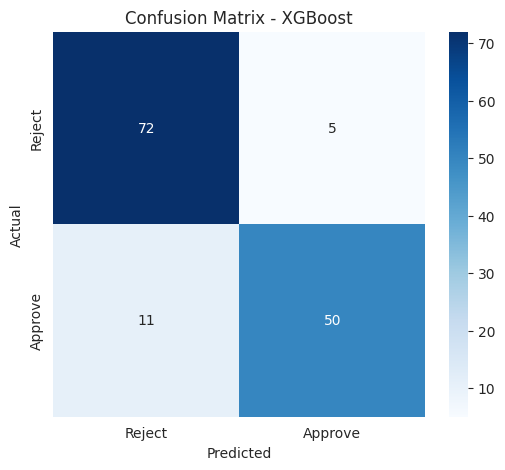

In [251]:
#confusion matrix
cm = confusion_matrix(y_test,ypred_test_xgb_tuned)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Reject','Approve'], yticklabels=['Reject','Approve'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost')
plt.show()

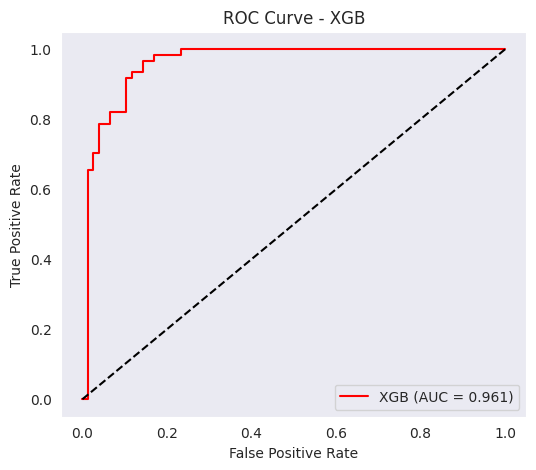

In [253]:
#ROC-AUC curve
yprob_xgb = tuned_xgb.predict_proba(X_test_preprocessed)[:,1]
auc_score = roc_auc_score(y_test, yprob_xgb)
fpr, tpr, thresholds = roc_curve(y_test, yprob_xgb)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"XGB (AUC = {auc_score:.3f})",color='red')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGB')
plt.legend(loc='lower right')
plt.show()

In [260]:
#saving model
joblib.dump(tuned_xgb,'model.pkl')

['model.pkl']